In [35]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [36]:
%cd /content/gdrive/My Drive/Colab Notebooks/Classification_Bankruptcy/5조 

/content/gdrive/My Drive/Colab Notebooks/Classification_Bankruptcy/5조


In [0]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 0. Import Raw Data

In [38]:
df = pd.read_csv('na_filled_train.csv') # '?' -> NA 변환한 파일 
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,-0.024558,0.30051,0.10733,1.8368,34.382,-0.026711,-0.020067,2.2519,1.06670,0.67673,-0.020067,-0.15646,0.025634,-0.020067,6342.50,0.057548,3.3276,-0.020067,-0.029744,26.775,1.08530,0.00866,-0.036400,-0.019018,0.67673,0.042607,0.13691,0.14041,4.5645,0.44185,-0.029744,74.015,4.9315,0.028816,0.00866,0.69446,1.0804,0.84898,0.012835,0.026591,0.214680,0.012835,125.6100,98.8360,-0.49620,1.4510,28.560,-0.028702,-0.042542,0.78396,0.12826,0.20278,0.8853,1.1106,3937.6000,0.062497,-0.036289,0.93750,0.25454,13.6320,3.6930,69.389,5.2602,0.8826,0
1,0.639180,0.00000,1.00000,NaN,29.678,-1.139300,0.760520,NaN,1.11850,1.00000,0.760520,NaN,0.679940,0.760520,0.00,NaN,NaN,0.760520,0.679940,0.000,NaN,0.76040,0.571460,0.600720,-0.50015,NaN,NaN,NaN,1.2218,0.00000,0.679940,0.000,NaN,NaN,0.76040,1.11850,NaN,1.00000,0.679830,NaN,0.000000,0.679830,9.6341,9.6341,NaN,NaN,0.000,0.760400,0.679830,NaN,0.00000,0.00000,NaN,NaN,16.6650,0.679830,0.639180,0.32014,0.00000,NaN,37.8860,0.000,NaN,NaN,0
2,-0.440760,0.47723,0.19260,1.4678,34.555,0.000000,-0.440760,1.0954,1.51860,0.52277,-0.429190,-1.07060,-0.240740,-0.440760,-476.47,-0.766050,2.0954,-0.440760,-0.290240,0.000,0.50040,-0.42986,-0.290240,0.744700,0.46954,-0.766050,-37.14700,0.48672,2.9728,0.31392,-0.282620,76.670,4.7606,4.106800,-0.44130,1.51860,9.2192,0.58832,-0.290590,0.029665,-0.044852,-0.283060,142.3100,142.3100,NaN,1.4678,0.000,-0.505040,-0.332570,1.26620,0.41169,0.21006,1.3211,1.4867,180.9100,-0.290590,-0.843130,1.28710,0.12538,NaN,2.5649,98.950,3.6887,3.8376,0
3,0.119520,0.17679,0.63546,4.5944,117.650,0.251540,0.148750,4.5826,1.12630,0.81017,0.148750,0.84137,0.131500,0.148750,306.88,1.189400,5.6563,0.148750,0.093023,40.872,0.97491,0.14495,0.074743,0.315270,0.81017,1.024100,1.02090,3.38460,5.4536,-0.18039,0.093023,45.450,8.0308,0.819900,0.14495,1.62200,NaN,0.81017,0.090649,2.702300,0.028150,0.090649,76.3540,35.4820,0.66747,3.5815,46.033,0.083425,0.052172,4.59440,0.17679,0.12452,4.3151,4.3151,180570.0000,0.112110,0.147520,0.88789,0.00000,8.9302,10.2870,40.355,9.0448,8.5169,0
4,0.230400,0.27095,0.23762,2.5745,-26.928,0.617540,0.282690,2.6907,0.80411,0.72905,0.284330,1.87320,0.390160,0.282690,315.23,1.157900,3.6907,0.282690,0.351560,46.043,1.44160,0.28433,0.286520,0.616550,0.62819,0.964870,173.05000,0.38860,7.2973,0.33696,0.351560,126.760,3.4578,1.925900,0.36955,0.80411,2.3916,0.84909,0.459570,1.102400,0.028638,0.353600,100.8400,54.8010,2.27140,1.9024,70.950,0.253300,0.315000,1.43390,0.15091,0.28920,1.1923,1.3886,2.5745,0.459570,0.316020,0.62320,0.16465,7.9274,6.6605,68.502,5.3283,1.3150,0


In [39]:
print(f"Shape: {df.shape}")
print(df.isnull().sum())

Shape: (6855, 65)
Attr1        0
Attr2        0
Attr3        0
Attr4       28
Attr5       15
Attr6        0
Attr7        0
Attr8       15
Attr9        0
Attr10       0
Attr11       0
Attr12      28
Attr13      14
Attr14       0
Attr15       5
Attr16      15
Attr17      15
Attr18       0
Attr19      14
Attr20      14
Attr21     112
Attr22       0
Attr23      14
Attr24     149
Attr25       0
Attr26      15
Attr27     462
Attr28     162
Attr29       0
Attr30      14
Attr31      14
Attr32      72
Attr33      28
Attr34      15
Attr35       0
Attr36       0
Attr37    3100
Attr38       0
Attr39      14
Attr40      28
Attr41     142
Attr42      14
Attr43      14
Attr44      14
Attr45     418
Attr46      28
Attr47      57
Attr48       0
Attr49      14
Attr50      15
Attr51       0
Attr52      60
Attr53     162
Attr54     162
Attr55       0
Attr56      14
Attr57       1
Attr58      10
Attr59       1
Attr60     420
Attr61      20
Attr62      14
Attr63      28
Attr64     162
class        0
dtype: 

# 1. NA imputation
## 1-1. Outliers 제거

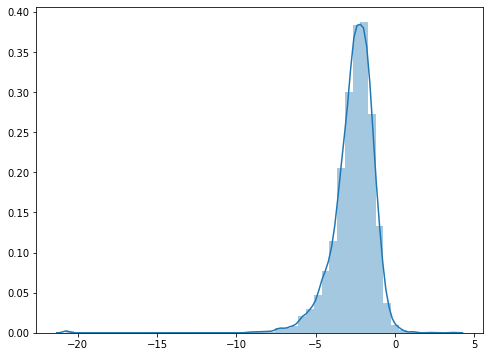

In [40]:
import seaborn as sns
fig = plt.figure(figsize = (8,6))
sns.distplot(np.log(df['Attr11'].dropna().replace(0, 1e-9).values));

In [41]:
df['Attr11'].sort_values(ascending=True).index[0]

423

이런 식으로 density plot을 본 이후 수작업으로 아웃라이어들이 포함된 관측치를 삭제해준다. <br>
하지만 class 1에 해당하는 관측치가 매우 적으니 아웃라이어여도 class 1, 즉 부도난 회사의 데이터면 삭제하지 않는다.

In [0]:
drop_rows = {2555,2099,4994,1458,3074,1593,5377,423,1207,1934,1593} |  \
{423, 998, 2555, 3527, 5249, 5313, 2654, 5810, 2008, 4192, 2099, 6665, 3074, 1458, 6424, 1593, 6232}

In [0]:
for row in drop_rows:
    if df['class'][row] == 1:
        continue
    elif df['class'][row] == 0:
        df.drop(row, axis=0, inplace=True)

In [44]:
df.reset_index(inplace=True, drop=True)
print(df.shape) # 19 rows are deleted

(6836, 65)


In [0]:
df = pd.read_csv('outlier_removed_train.csv')

In [0]:
df.drop(6360, inplace=True) # sales < 0인 행 삭제(오입력 가능성)
df.reset_index(inplace=True, drop=True)

## 1-2. Recovering some variables..

In [0]:
total_assets = pd.Series(np.exp(df['Attr29']), index=df['Attr29'].index)
assert not bool(total_assets.isnull().sum())

total_equity = df['Attr10']* total_assets
assert not bool(total_equity.isnull().sum())

total_liabilities = total_assets - total_equity
assert not bool(total_liabilities.isnull().sum())

short_term_liabilities =  df['Attr51']  * total_assets
assert not bool(short_term_liabilities.isnull().sum())

long_term_liabilities = total_liabilities - short_term_liabilities
assert not bool(long_term_liabilities.isnull().sum())

total_sales = pd.Series(np.array(total_assets) * np.array(df['Attr36']))
assert not bool(total_sales.isnull().sum())

sales = total_assets* df['Attr9'].values
assert not bool(sales.isnull().sum())

gross_profit = total_assets * df['Attr18']
assert not bool(gross_profit.isnull().sum())

EBIT = total_assets * df['Attr7']
assert not bool(EBIT.isnull().sum())

EBITDA = total_assets * df['Attr48']
assert not bool(EBITDA.isnull().sum())

retained_earnings = total_assets * df['Attr6']
assert not bool(retained_earnings.isnull().sum())

net_profit = total_assets * df['Attr1']
assert not bool(net_profit.isnull().sum())

working_capital = total_assets * df['Attr3']
profit_on_sales = total_assets * df['Attr35']
assert not bool(working_capital.isnull().sum())
assert not bool(profit_on_sales.isnull().sum())

total_assets, total_equity, total_liabilities, short_term_liabilities, long_term_liabilities, total_sales, sales, gross_propit, retained_earnings, EBIT, EBITDA, net_profit, working_capital, profit_on_sales 을 구할 수 있었다.

## 1-3. Drop useless columns
변수가 가지고 있는 정보가 겹치거나, 눈으로 보았을 때 명확한 선형관계가 존재하면 제거해준다

In [0]:
drop_list = []
for i in (15,17,19,20,28,31,34,37,41,42,44,46,55,57,62):
    drop_list.append("Attr" + str(i))
    
df.drop(drop_list, axis=1, inplace=True)

In [49]:
print(df.shape) # 15 columns are removed

(6835, 50)


In [50]:
print(df.isnull().sum())

Attr1       0
Attr2       0
Attr3       0
Attr4       0
Attr5      15
Attr6       0
Attr7       0
Attr8      13
Attr9       0
Attr10      0
Attr11      0
Attr12     25
Attr13     13
Attr14      0
Attr16     13
Attr18      0
Attr21    110
Attr22      0
Attr23     13
Attr24    149
Attr25      0
Attr26     13
Attr27    459
Attr29      0
Attr30     13
Attr32     71
Attr33     25
Attr35      0
Attr36      0
Attr38      0
Attr39     13
Attr40     25
Attr43     13
Attr45    410
Attr47     56
Attr48      0
Attr49     13
Attr50     13
Attr51      0
Attr52     59
Attr53    159
Attr54    159
Attr56     13
Attr58      9
Attr59      1
Attr60    412
Attr61     19
Attr63     25
Attr64    159
class       0
dtype: int64


참고) 여기서  Attr4는 current_assets 가 na imputation 된 값이 입력되어있음. <br>
순서가 꼬여서 이렇게 되었으나, 이후 코딩에서 별 문제는 없음. 

current_assets를 먼저 imputation한 이유는 이와 연관된 변수가 많아서였음.

current_assets 정보가 들어가 있는 변수 중 NA 갯수가 가장 적은 변수를 선택하여 imputation함.
(코드는 아래와 같음)

In [0]:
current_assets = df['Attr50'] * total_liabilities
current_assets.fillna(30.04, inplace=True)
assert not bool(current_assets.isnull().sum())

## 1-4. Direct NA Imputation using recovered information

In [0]:
# 0이 존재하는 값에 최솟값(절댓값)을 더해준다

min_short_term_liabilities = [x for x in np.sort(np.abs(short_term_liabilities)) if x][0]
short_term_liabilities.replace(0, min_short_term_liabilities, inplace=True)
        
min_sales = [x for x in np.sort(np.abs(sales)) if x][0]
sales.replace(0, min_sales, inplace=True)

min_total_liabilities = [x for x in np.sort(np.abs(total_liabilities)) if x][0]
total_liabilities.replace(0, min_total_liabilities, inplace=True)

min_total_equity = [x for x in np.sort(np.abs(total_equity)) if x][0]
total_equity.replace(0, min_total_equity, inplace=True)

In [53]:
print(min_short_term_liabilities, min_sales, min_total_liabilities, min_total_equity)

0.0011085237977033703 0.0018897056105588663 0.0010846612502000141 0.037702938739959564


이제 분모에 0이 오기 때문에 NA가 될 걱정은 사라졌으니 이를 이용해서 NA imputation을 해보자!

In [0]:
df['Attr12'] = gross_profit / short_term_liabilities
df['Attr23'] = net_profit / sales
df['Attr39'] = profit_on_sales / sales
df['Attr49'] = EBITDA / sales
df['Attr50'] = current_assets / total_liabilities
df['Attr59'] = long_term_liabilities / total_equity
df['Attr63'] = sales / short_term_liabilities

In [55]:
# na 값 있나 확인
df.loc[:, ['Attr12','Attr23','Attr39','Attr49','Attr50','Attr59','Attr63']].isnull().sum()

Attr12    0
Attr23    0
Attr39    0
Attr49    0
Attr50    0
Attr59    0
Attr63    0
dtype: int64

## 1-5. Using packages specialized in NA Imputation 
### 1-5-0. Measuring performance of Logistic Regression with na removed data

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import warnings

warnings.filterwarnings('ignore')

na_dropped = df.dropna(axis = 0)
X, y = na_dropped.iloc[:, :-1], na_dropped.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state=5)

lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print(f1_score(y_test, y_pred))

0.08823529411764706


ㅎㅎ na imputation을 꼭 해야할듯하다

### 1-5-1. Simple Imputation

In [0]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]

In [0]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

simple_mean_impute = Pipeline([("Simple", SimpleImputer(np.nan, "mean")), 
                        ("clf", LogisticRegression(class_weight='balanced'))])

simple_median_impute = Pipeline([("Simple", SimpleImputer(np.nan, "median")), 
                        ("clf", LogisticRegression(class_weight='balanced'))])

일관성 있는 na imputation method를 고르기 위해 평가는 cross-validated f1 score로 하겠음

In [0]:
from sklearn.model_selection import cross_val_score
import warnings

warnings.filterwarnings('ignore')

simple_mean_score = cross_val_score(simple_mean_impute, X, y, scoring='f1').mean()
simple_median_score = cross_val_score(simple_median_impute, X, y, scoring='f1').mean()

In [69]:
print(simple_mean_score, simple_median_score)

0.17243855095500826 0.17690922819712987


score가 많이 올라감

### 1-5-2. KNN imputation

In [0]:
from sklearn.impute import KNNImputer

knn_impute = Pipeline([("KNN", KNNImputer()), 
                        ("clf", LogisticRegression(class_weight='balanced'))])

In [71]:
knn_score = cross_val_score(knn_impute, X, y, scoring='f1').mean()
print(knn_score)

0.15674874087391394


### 1-5-3. Bayesian Ridge imputation

In [0]:
from sklearn.linear_model import BayesianRidge

bayesian_impute = Pipeline([("Bayesian", IterativeImputer(estimator=BayesianRidge(),
                                                max_iter=10, random_state=5, verbose=0)), 
                        ("clf", LogisticRegression(class_weight='balanced'))])

In [73]:
bayesian_score = cross_val_score(bayesian_impute, X, y, scoring='f1').mean()
print(bayesian_score)

0.15667455143488532


### 1-5-4. Decision Tree imputation

In [0]:
from sklearn.tree import DecisionTreeRegressor

decision_tree_impute = Pipeline([("Decision Tree", 
                                  IterativeImputer(estimator=DecisionTreeRegressor(max_features='sqrt', random_state=5),
                                                max_iter=10, random_state=5, verbose=0)), 
                                 ("clf", LogisticRegression(class_weight='balanced'))])

In [75]:
decision_tree_score = cross_val_score(decision_tree_impute, X, y, scoring='f1').mean()
print(decision_tree_score)

0.1576509455456824


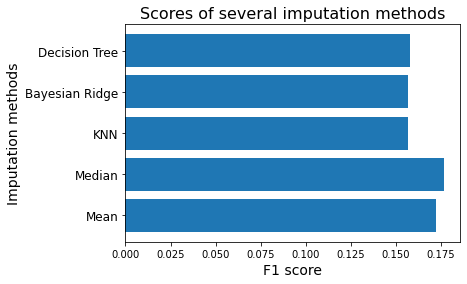

In [77]:
imputation_methods = np.array(['Mean', 'Median', 'KNN', 'Bayesian Ridge', 'Decision Tree'])
imputation_scores = np.array([simple_mean_score, simple_median_score, knn_score, bayesian_score, decision_tree_score])
index = np.arange(1, 6)

plt.barh(index, imputation_scores)
plt.title('Scores of several imputation methods', fontsize=16)
plt.xlabel('F1 score', fontsize=14)
plt.ylabel('Imputation methods', fontsize=14)
plt.yticks(index, imputation_methods, fontsize=12)
plt.show()

<b> Let's go with Median Imputer! </b>

In [78]:
df.isnull().sum()

Attr1       0
Attr2       0
Attr3       0
Attr4       0
Attr5      15
Attr6       0
Attr7       0
Attr8      13
Attr9       0
Attr10      0
Attr11      0
Attr12      0
Attr13     13
Attr14      0
Attr16     13
Attr18      0
Attr21    110
Attr22      0
Attr23      0
Attr24    149
Attr25      0
Attr26     13
Attr27    459
Attr29      0
Attr30     13
Attr32     71
Attr33     25
Attr35      0
Attr36      0
Attr38      0
Attr39      0
Attr40     25
Attr43     13
Attr45    410
Attr47     56
Attr48      0
Attr49      0
Attr50      0
Attr51      0
Attr52     59
Attr53    159
Attr54    159
Attr56     13
Attr58      9
Attr59      0
Attr60    412
Attr61     19
Attr63      0
Attr64    159
class       0
dtype: int64

In [0]:
imputer = SimpleImputer(np.nan, "median")
df_imputed = imputer.fit_transform(df)
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

In [80]:
# 마지막 확인
df_imputed.isnull().sum()

Attr1     0
Attr2     0
Attr3     0
Attr4     0
Attr5     0
Attr6     0
Attr7     0
Attr8     0
Attr9     0
Attr10    0
Attr11    0
Attr12    0
Attr13    0
Attr14    0
Attr16    0
Attr18    0
Attr21    0
Attr22    0
Attr23    0
Attr24    0
Attr25    0
Attr26    0
Attr27    0
Attr29    0
Attr30    0
Attr32    0
Attr33    0
Attr35    0
Attr36    0
Attr38    0
Attr39    0
Attr40    0
Attr43    0
Attr45    0
Attr47    0
Attr48    0
Attr49    0
Attr50    0
Attr51    0
Attr52    0
Attr53    0
Attr54    0
Attr56    0
Attr58    0
Attr59    0
Attr60    0
Attr61    0
Attr63    0
Attr64    0
class     0
dtype: int64

In [0]:
df_imputed.to_csv('imputed_final.csv', index=False)

In [86]:
pd.read_csv('imputed_final.csv').head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr16,Attr18,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr29,Attr30,Attr32,Attr33,Attr35,Attr36,Attr38,Attr39,Attr40,Attr43,Attr45,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr56,Attr58,Attr59,Attr60,Attr61,Attr63,Attr64,class
0,-0.024558,0.30051,0.10733,1.975914,34.382,-0.026711,-0.020067,2.25190,1.06670,0.67673,-0.020067,-0.156456,0.025634,-0.020067,0.057548,-0.020067,1.08530,0.00866,-0.023022,-0.019018,0.67673,0.042607,0.13691,4.5645,0.44185,74.015,4.9315,0.00866,0.69446,0.84898,0.008118,0.026591,125.6100,-0.49620,28.560,-0.028702,-0.026907,0.783960,0.12826,0.20278,0.88530,1.1106,0.062497,0.93750,0.288165,13.6320,3.6930,8.316700,0.88260,0.0
1,0.639180,0.00000,1.00000,5006.666667,29.678,-1.139300,0.760520,1.09245,1.11850,1.00000,0.760520,2328.019515,0.679940,0.760520,0.222805,0.760520,1.04790,0.76040,0.571462,0.600720,-0.50015,0.203820,1.01190,1.2218,0.00000,0.000,4.4510,0.76040,1.11850,1.00000,0.679839,0.177130,9.6341,0.23541,0.000,0.760400,0.679839,27695.282739,0.00000,0.00000,1.20865,1.3747,0.679830,0.32014,0.000000,9.5619,37.8860,3423.828207,4.01995,0.0
2,-0.440760,0.47723,0.19260,1.467776,34.555,0.000000,-0.440760,1.09540,1.51860,0.52277,-0.429190,-1.070611,-0.240740,-0.440760,-0.766050,-0.440760,0.50040,-0.42986,-0.290241,0.744700,0.46954,-0.766050,-37.14700,2.9728,0.31392,76.670,4.7606,-0.44130,1.51860,0.58832,-0.290597,0.029665,142.3100,0.23541,0.000,-0.505040,-0.332569,1.266200,0.41169,0.21006,1.32110,1.4867,-0.290590,1.28710,0.125371,9.5619,2.5649,3.688698,3.83760,0.0
3,0.119520,0.17679,0.63546,4.933282,117.650,0.251540,0.148750,4.58260,1.12630,0.81017,0.148750,0.841394,0.131500,0.148750,1.189400,0.148750,0.97491,0.14495,0.106117,0.315270,0.81017,1.024100,1.02090,5.4536,-0.18039,45.450,8.0308,0.14495,1.62200,0.81017,0.128696,2.702300,76.3540,0.66747,46.033,0.083425,0.074070,4.594400,0.17679,0.12452,4.31510,4.3151,0.112110,0.88789,0.016095,8.9302,10.2870,6.370835,8.51690,0.0
4,0.230400,0.27095,0.23762,2.574483,-26.928,0.617540,0.282690,2.69070,0.80411,0.72905,0.284330,1.873236,0.390160,0.282690,1.157900,0.282690,1.44160,0.28433,0.286528,0.616550,0.62819,0.964870,173.05000,7.2973,0.33696,126.760,3.4578,0.36955,0.80411,0.84909,0.459576,1.102400,100.8400,2.27140,70.950,0.253300,0.315007,1.433900,0.15091,0.28920,1.19230,1.3886,0.459570,0.62320,0.164653,7.9274,6.6605,5.328408,1.31500,0.0
